**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & Prof. Antonio Ortega (aortega@usc.edu)

**Teaching Assistant**: Alexios Rustom (arustom@usc.edu)

**Book**: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

**Notebooks**: Written by Alexios Rustom (arustom@usc.edu) and Prof. Keith Chugg (chugg@usc.edu)

In [22]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import datasets
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score

In [23]:
def load_MNIST_data(data_path, fashion=False, quiet=False):
    if not fashion:
        train_set = datasets.MNIST(data_path, download=True, train=True)
        test_set = datasets.MNIST(data_path, download=True, train=False)
    else:
        train_set = datasets.FashionMNIST(data_path, download=True, train=True)
        test_set = datasets.FashionMNIST(data_path, download=True, train=False)      
    x_train = train_set.data.numpy()
    y_train = train_set.targets.numpy()

    x_test = test_set.data.numpy()
    y_test = test_set.targets.numpy()
    
    N_train, H, W = x_train.shape
    N_test, H, W = x_test.shape

    if not quiet:
        print(f'The data are {H} x {W} grayscale images.')
        print(f'N_train = {N_train}')
        print(f'N_test = {N_test}')
    for i in set(y_train):
        N_i_train = np.sum(y_train==i)
        N_i_test = np.sum(y_test==i)
        if not quiet:
            print(f'Class {i}: has {N_i_train} train images ({100 * N_i_train / N_train : .2f} %), {N_i_test} test images ({100 * N_i_test/ N_test : .2f} %) ')
    return x_train, y_train, x_test, y_test

In [24]:
def extract_two_classes(x, labels, class_1, class_2):
    x_1 = x[labels==class_1]
    y_1 = np.ones(x_1.shape[0], dtype=int) * class_1
    x_2 = x[labels==class_2]
    y_2 = np.ones(x_2.shape[0], dtype=int) * class_2
    
    x_shape = x.shape
    N1 = len(y_1)
    N2 = len(y_2)
    N_12 = N1 + N2
    x_12 = np.zeros((N_12, x_shape[1], x_shape[2]))
    x_12[:N1] = x_1
    x_12[N1:] = x_2

    print(f'Class {class_1}: has {N1} images ({100 * N1 / (N_12) : .2f} %)')
    print(f'Class {class_2}: has {N2} images ({100 * N2 / (N_12) : .2f} %)')

    return x_12, np.append(y_1, y_2)

##  K-means Clustering

- One very simple way to simplify a dataset is by grouping together nearby points into *clusters*.  

- We will denote our set of $P$ points generically as $\mathbf{x}_1,\,\mathbf{x}_2,\,...,\mathbf{x}_P$$ all of dimension $N$. 

- To keep things as generally applicable as possible we will also use the notation $K$ to denote the number of clusters in a dataset.  

- Because each cluster has a centroid we need notation for this as well, and we will use $\mathbf{c}_1,\,\mathbf{c}_2,\,...,\mathbf{c}_K$ to denote these where $\mathbf{c}_k$ is the centroid of the $k^{th}$ cluster.  


- Finally we need a notation to denote the set of points that belong to each cluster.  We denote the set of indices of those points belonging to the $k^{th}$ cluster as

\begin{equation}
\mathcal{S}_k =  \left\{ p\,\, \lvert \,\,\text{if $\mathbf{x}_p$ belongs to the $k^{th}$ cluster } \right\}.
\end{equation}

- With all of our notation in hand we can now better describe the clustering scenario.  


- Again, note here we have assumed that we have identified each cluster and its centroid.  


- Firstly, because the centroid denotes the center of a cluster it seems intuitive that each one should be expressible as the average of the points assigned to each cluster.  

- Algebraically this is to say that

\begin{equation}
\mathbf{c}_k = \frac{1}{\left\vert\mathcal{S}_k\right\vert}\sum_{p\in\mathcal{S}_k}\mathbf{x}_p.
\end{equation}


- This formula confirms the intuition that each centroid represents a chunk of the data - the average of those points belonging to each cluster.  


- Next we can state mathematically an obvious and implicit fact about the clustering scenario above: that each point belongs to the cluster whose centroid it is closest to. 

- To express this algebraically for a given point $\mathbf{x}_p$ is simply say that the point must belong to the cluster where the distance to the centroid $\left\Vert \mathbf{x}_p - \mathbf{c}_k \right\Vert_2$ is minimal.  


- In other words, the point $\mathbf{x}_p$ belongs to or is *assigned* to cluster $k^{\star}$ if

\begin{equation}
a_p = \underset{k=1,...,K}{\text{argmin}} \,\,\,\left\Vert \mathbf{x}_p - \mathbf{c}_k \right\Vert_2
\end{equation}

- In the jargon of machine learning these are called cluster *assignments*.

###  Learning clusters to represent data

- We do not want to have to visually identify clusters in a dataset ourselves, and in any being constrained three dimensions if the dimension of of a dataset is greater than $N=3$ there is no way for us humans to do this anyway.  Instead we want an algorithm that will do this for us automatically.

- Thankfully we can do this rather easily using the framework detailed above for mathematically describing clusters - the resulting algorithm being called the *K-means clustering algorithm*.  As with many of the algorithms we have seen K-means is an *iterative method*, meaning that we will refine the ideal location for our cluster centroids / cluster assignments over a number of update steps.

- To get started -  let us say that we want to cluster a dataset of $P$ points into $K$ clusters automatically.  


- Note here that we will fix $K$, and address how to properly decide on its value later.  


- Now to state the obvious - remember - we know neither a) the locations of each cluster centroid nor b) the cluster assignments.

- Since we do not know where the clusters nor their centroids are located we can start off by taking a random guess at the locations of our $K$ centroids (we have to start somewhere).  


- This 'random guess' - our initialization - for the $K$ centroids could be a random subset of $K$ of our points, or any number of other types of initialization.

- With our initial centroid locations decided on we can then determine cluster assignments by simply looping over our points and for each $\mathbf{x}_p$ finding its closest centroid using the formula we saw above

\begin{equation}
a_p = \underset{k=1,...,K}{\text{argmin}} \,\,\,\left\Vert \mathbf{x}_p - \mathbf{c}_k \right\Vert_2.
\end{equation}

- Now we have both an initial guess at our centroids and clustering assignments.  


- With our cluster assignments in hand we can then update our centroid locations - as the average of the points assigned to each cluster

\begin{equation}
\mathbf{c}_k = \frac{1}{\left\vert\mathcal{S}_k\right\vert}\sum_{p\in\mathcal{S}_k}\mathbf{x}_p.
\end{equation}

- To further refine our centroids / clusters we can now just repeat the above two-step process of re-assigning points based on our new centroid locations and then updating the centroid locations as the average of those points assigned to each cluster.  


- We can halt doing so after e.g., a pre-defined number of maximum iterations or when the cluster centroids to not change location very much from one iteration to the next.

### The K-means algorithm

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">

<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> dataset $\mathbf{x}_1,\cdots,\mathbf{x}_P$, initializations for centroids $\mathbf{c}_1,...,\mathbf{c}_K$, and maximum number of iterations $J$ <br>

<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,j = 1,\ldots,J$<br>

<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update cluster assignments</code><br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $a_p =\underset{k=1,\ldots,K}{\text{argmin}}\,\,\left\Vert \mathbf{c}_{k}-\mathbf{x}_{p}\right\Vert _{2}$<br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update centroid locations</code><br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,k = 1,\ldots,K$<br>

<strong>9:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; denote $\mathcal{S}_{k}$ the index set of points $\mathbf{x}_{p}$ currently assigned to the $k^{th}$ cluster<br>

<strong>10:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; update $\mathbf{c}_k$ via $\mathbf{c}_{k}=\frac{1}{\left|\mathcal{S}_{k}\right|}\underset{p\in\mathcal{S}_{k}}{\sum}\mathbf{x}_{p}$<br>

<strong>11:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>12:</strong>&nbsp; <code>end for</code><br>

<strong>13:</strong>&nbsp;&nbsp; <code># Update cluster assignments using final centroids</code><br>

<strong>14:</strong>&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>15:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $a_p =\underset{k=1,\ldots,K}{\text{argmin}}\,\,\left\Vert \mathbf{c}_{k}-\mathbf{x}_{p}\right\Vert _{2}$<br>

<strong>16:</strong>&nbsp;&nbsp; <code>end for</code><br>

<strong>17:</strong>&nbsp; <strong>output:</strong> optimal centroids and assignments<br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

In [25]:
USE_FASHION_MNIST = False
if USE_FASHION_MNIST:
    tag_name = 'FashionMNIST'
else:
    tag_name = 'MNIST'
    
x_train, y_train, x_test, y_test = load_MNIST_data('./data/', fashion=USE_FASHION_MNIST, quiet=False)

The data are 28 x 28 grayscale images.
N_train = 60000
N_test = 10000
Class 0: has 5923 train images ( 9.87 %), 980 test images ( 9.80 %) 
Class 1: has 6742 train images ( 11.24 %), 1135 test images ( 11.35 %) 
Class 2: has 5958 train images ( 9.93 %), 1032 test images ( 10.32 %) 
Class 3: has 6131 train images ( 10.22 %), 1010 test images ( 10.10 %) 
Class 4: has 5842 train images ( 9.74 %), 982 test images ( 9.82 %) 
Class 5: has 5421 train images ( 9.04 %), 892 test images ( 8.92 %) 
Class 6: has 5918 train images ( 9.86 %), 958 test images ( 9.58 %) 
Class 7: has 6265 train images ( 10.44 %), 1028 test images ( 10.28 %) 
Class 8: has 5851 train images ( 9.75 %), 974 test images ( 9.74 %) 
Class 9: has 5949 train images ( 9.91 %), 1009 test images ( 10.09 %) 


<Figure size 640x480 with 0 Axes>

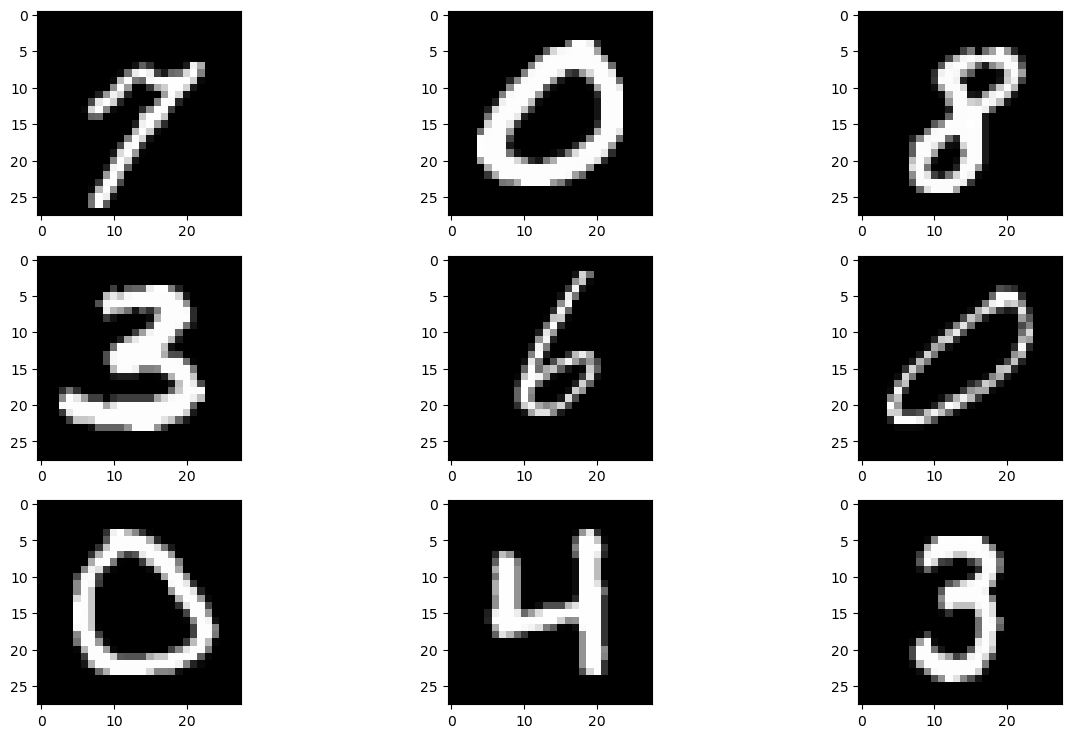

In [26]:
plt.gray() # B/W Images
plt.figure(figsize = (15,9)) # Adjusting figure size
# Displaying a grid of 3x3 images
for i in range(9):
    index = np.random.randint(low=0, high=len(y_train), dtype=int)
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[index])
plt.show()

In [27]:
x_train_float = x_train.astype("float32") 
x_test_float = x_test.astype("float32")
# Normalization
x_train_normalized = x_train_float/255.0
x_test_normalized = x_test_float/255.0

In [28]:
X_train = x_train_normalized.reshape(len(x_train_normalized),-1) #reshape to fed into k_means clustering
X_test = x_test_normalized.reshape(len(x_test_normalized),-1) #reshape to fed into k_means clustering

print(f'x_train_normalized.shape: {x_train_normalized.shape}')
print(f'X_train.shape: {X_train.shape}')

x_train_normalized.shape: (60000, 28, 28)
X_train.shape: (60000, 784)


# Using `sklearn.cluster.MiniBatchKMeans` for K-means Clustering

In [29]:
num_clusters = len(np.unique(y_test))
print('Number of Clusters: ', num_clusters)

Number of Clusters:  10


Notice below, we never give `MiniBatchKMeans` the labels, so it is finding the clusters in an unsupervised manner.

In [30]:
#n_init Number of random initializations that are tried. In contrast to KMeans, the algorithm is only run once, using the best of the n_init initializations as measured by inertia
kmeans = MiniBatchKMeans(n_clusters = num_clusters, n_init=20)
kmeans.fit(X_train)  ##

MiniBatchKMeans(n_clusters=10, n_init=20)

# Interpreting the clusters
In order to intepret the clusters that were found, since we actually know the labels, let's associate with each cluster a label.  We can do this by majority vote.  Specifically, we will associate the class label of the class that has the most points in the cluster with that cluster. 

Note that this is using the labels.  Alternatively, we could simply classify the data according to what cluster they belong.  If we did this, a human could then expect the clusterhead and perhaps draw meaning, effectively labeling the data.  As another example, if you do a similar experiment clustering congressmembers by their voting patterns, you will get two clusters.  Visual inspection of this will reveal that one corresponds to democrats and the other to republicans.  

In [38]:
#this will assign each cluster (0:num_clusters) to its corresponding label (0 to 9)
def retrieve_info(cluster_labels,y_train):
    reference_labels = {}
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

As a fairly naive experiment, let's try classifying a data vector by using a nearest means approach.  Specifically, we take a given data vector, find it's nearest clsuterhead, and take the majority-vote label of that cluster as the classification decision.

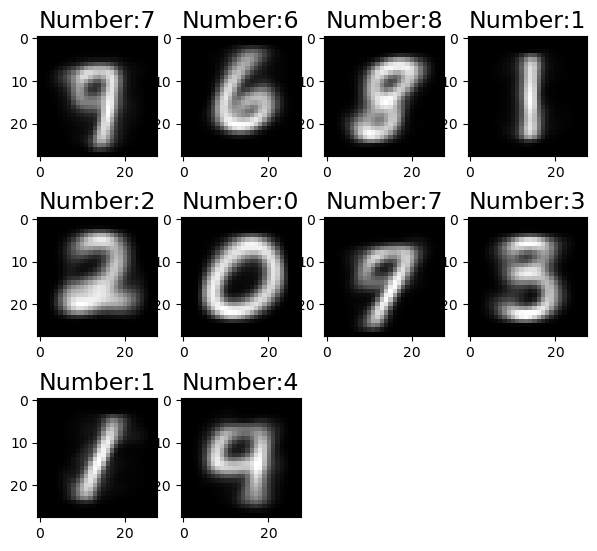

In [39]:
reference_labels_train = retrieve_info(kmeans.labels_,y_train)
reference_labels_test = retrieve_info(labels_test,y_test)

centroids = kmeans.cluster_centers_.reshape(num_clusters,28,28)
centroids = centroids * 255
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(num_clusters):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.title("Number:{}".format(reference_labels_test[i]),fontsize = 17)
    plt.imshow(centroids[i])


Notice that several clusters were asssigned the same labels.  It doesn't pay to be a 5!  In other words, we recall that 5s are easily confused for other digits, so 5s are most likely spread out amoung the clusters.  

In [40]:
predicted_labels_train = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    predicted_labels_train[i] = reference_labels_train[kmeans.labels_[i]]

In [41]:
print('Training Accuracy Score (%):',accuracy_score(predicted_labels_train,y_train)*100)

Training Accuracy Score (%): 59.47833333333333


In [42]:
labels_test = kmeans.predict(X_test)

In [43]:
predicted_labels_test = np.random.rand(len(labels_test))
for i in range(len(labels_test)):
    predicted_labels_test[i] = reference_labels_test[labels_test[i]]
print('Test Accuracy Score (%):',accuracy_score(predicted_labels_test,y_test)*100)

Test Accuracy Score (%): 59.45


This does not do nearly as well as the least squares classifier we considered, but that is not surprising, since several clusters received the same labels. 

## PCA for reduced dimensional representation

Now, let's apply PCA.  

In [86]:
P = X_train.shape[0]
Kx = X_train.T @ X_train / P ## sample covariance matrix

e_vals, E_vecs = np.linalg.eig(Kx)

E_vecs = E_vecs.T
small_to_big = np.argsort(e_vals)
big_to_small = small_to_big[::-1]

e_vals = e_vals[big_to_small]
E_vecs = E_vecs[big_to_small]

Now that we have a basis of orthonormal eigenvectors of ${\bf X}^T {\bf X}$, we can express a given data vector

Let's see how the eigenvalues compare in value. 


 Also, the approximation is an orthogonal project, so 
\[
    \| {\bf x} - \hat{\bf x} \|^2 = \| \sum_{k=0}^{P-1} X_k |bf e_k 

lambdas: [38.09107    4.3901305  3.740976   3.2257082  2.7861931  2.277348
  1.918431   1.5361651  1.5180209  1.2460153]
(784,)


Text(0, 0.5, 'Percent Energy')

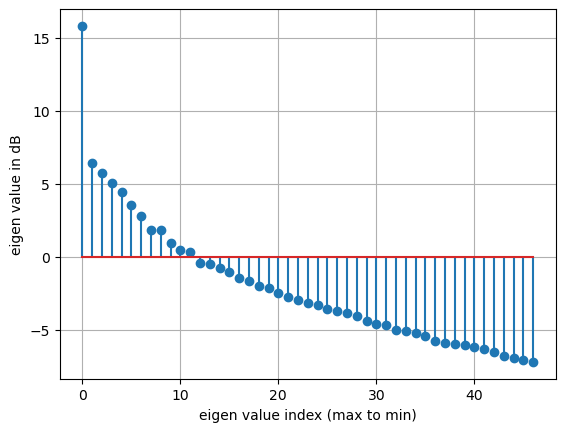

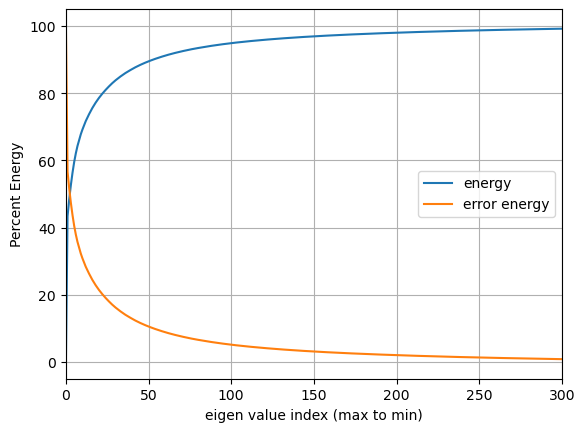

In [103]:
print(f'lambdas: {e_vals[:10]}')
plt.figure()
plt.stem(10 * np.log10(e_vals[:47]))
plt.grid(';')
plt.xlabel('eigen value index (max to min)')
plt.ylabel('eigen value in dB')

H_W = len(e_vals)
percent_energy = np.zeros(H_W)
for k in range(H_W):
    percent_energy[k] = np.sum(e_vals[:k])
percent_energy = 100 * percent_energy / np.sum(e_vals)

print(percent_energy.shape)
plt.figure()
plt.plot(np.arange(H_W), percent_energy, label='energy')
plt.plot(np.arange(H_W), 100 - percent_energy, label='error energy')
plt.grid(';')
plt.legend()
plt.xlim([0,300])
plt.xlabel('eigen value index (max to min)')
plt.ylabel('Percent Energy')

In [116]:
k_max = 50
coeff =  (E_vecs[:k_max] @ X_train.T).T
X_approx = coeff @ E_vecs[:k_max]
X_approx = X_approx.reshape(P, 28, 28)

<Figure size 640x480 with 0 Axes>

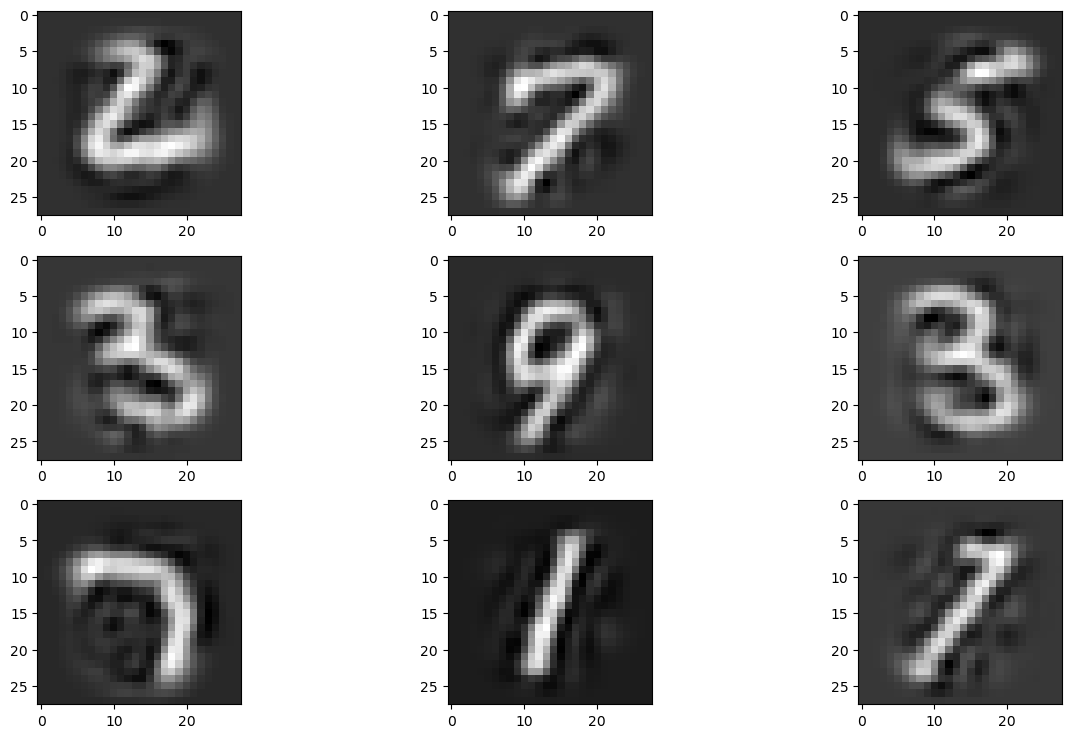

In [117]:
plt.gray() # B/W Images
plt.figure(figsize = (15,9)) # Adjusting figure size
# Displaying a grid of 3x3 images
for i in range(9):
    index = np.random.randint(low=0, high=len(y_train), dtype=int)
    plt.subplot(3,3,i+1)
    plt.imshow(X_approx[index])
plt.show()